# Brazil E-Commerce Data Analysis

This is a Brazilian ecommerce public dataset of orders made at Olist Store. 
    
The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. 

Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.

This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

# Data Schema

The data is divided in multiple datasets for better understanding and organization. Please refer to the following data schema when working with it:

<p><img src= "data/database_schema.png"/></p>

This dataset provides a lot of posibilities of use cases for Machine Learning and Data analysis.

Here are some of the possibilities that can be explored using this dataset: 
    
- Natural Language Processing (NLP): understanding the reviews provided by the customers through multiple dimensions

- Clustering: some customers did not provide reviews, but were they happy or not ?
    
- Sales Prediction: with the sales dates, can we be able to predict future sales ?
    
- Delivery performance: can we be able to optimize the delivery times
    
- Product Quality: which product categories are more prone to customer insatisfaction

- Feature engineering: attach some public information into this dataset or generate features from it

<h5>What about using SQL and Metabase for analysis ? </h5>

<p>This is a feasible approach since we can use SQL to analyze the data and create sharable dashboards using Metabase.

That will require the data to be modelled into our database before the analysis can begin</p>

The aim of this kernel is: 
    

<p>1. Understand the customer reviews using NLP techniques.</p>
<p>2. Create an interactive data analysis dashboard using Metabase that uncovers trends in sales patterns</p>


### Reading the data

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import requests
import folium
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go

from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime,LocateControl 

In [2]:
data_path = "data/"
olist_customer = pd.read_csv(data_path + 'olist_customers_dataset.csv')
olist_geolocation = pd.read_csv(data_path + 'olist_geolocation_dataset.csv')
olist_order_items = pd.read_csv(data_path + 'olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv(data_path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(data_path + 'olist_order_reviews_dataset.csv')
olist_orders = pd.read_csv(data_path + 'olist_orders_dataset.csv')
olist_products = pd.read_csv(data_path + 'olist_products_dataset.csv')
olist_sellers = pd.read_csv(data_path + 'olist_sellers_dataset.csv')
olist_product_naming = pd.read_csv(data_path + 'product_category_name_translation.csv')

brazil_adm = gpd.read_file(data_path+'BRA_adm1.shp')
adm_csv = pd.read_csv(data_path+'BRA_adm1.csv')

In [3]:
datasets = [olist_customer, olist_geolocation, olist_orders, 
            olist_order_items, olist_order_payments,olist_order_reviews,
            olist_products, olist_sellers, olist_product_naming, brazil_adm, adm_csv
           ]

names = ['olist_customer', 'olist_geolocation', 'olist_orders', 
            'olist_order_items', 'olist_order_payments','olist_order_reviews',
            'olist_products', 'olist_sellers', 'olist_product_naming', 'brazil_adm', 'adm_csv']

## Create a dictionary with useful information about the nature of all the datasets
data_view = pd.DataFrame({})
data_view['dataset'] = names
data_view['n_rows'] = [df.shape[0] for df in datasets]
data_view['n_cols'] = [df.shape[1] for df in datasets]
data_view['null_values'] = [df.isnull().sum().sum() for df in datasets]

data_view['number_of_nul_cols'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_view['null_columns'] = [','.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

In [4]:
data_view.style.highlight_between()

,dataset,n_rows,n_cols,null_values,number_of_nul_cols,null_columns
0,olist_customer,99441,5,0,0,
1,olist_geolocation,1000163,5,0,0,
2,olist_orders,99441,8,4908,3,"order_approved_at,order_delivered_carrier_date,order_delivered_customer_date"
3,olist_order_items,112650,7,0,0,
4,olist_order_payments,103886,5,0,0,
5,olist_order_reviews,99224,7,145903,2,"review_comment_title,review_comment_message"
6,olist_products,32951,9,2448,8,"product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm"
7,olist_sellers,3095,4,0,0,
8,olist_product_naming,71,2,0,0,
9,brazil_adm,27,13,68,3,"CCA_1,NL_NAME_1,VARNAME_1"


In [ ]:
df_overview = pd.DataFrame({})
name_col = []
for name, df in zip(names, datasets):
    name_col += [name]* df.shape[1]

## Exploratory Data Analysis

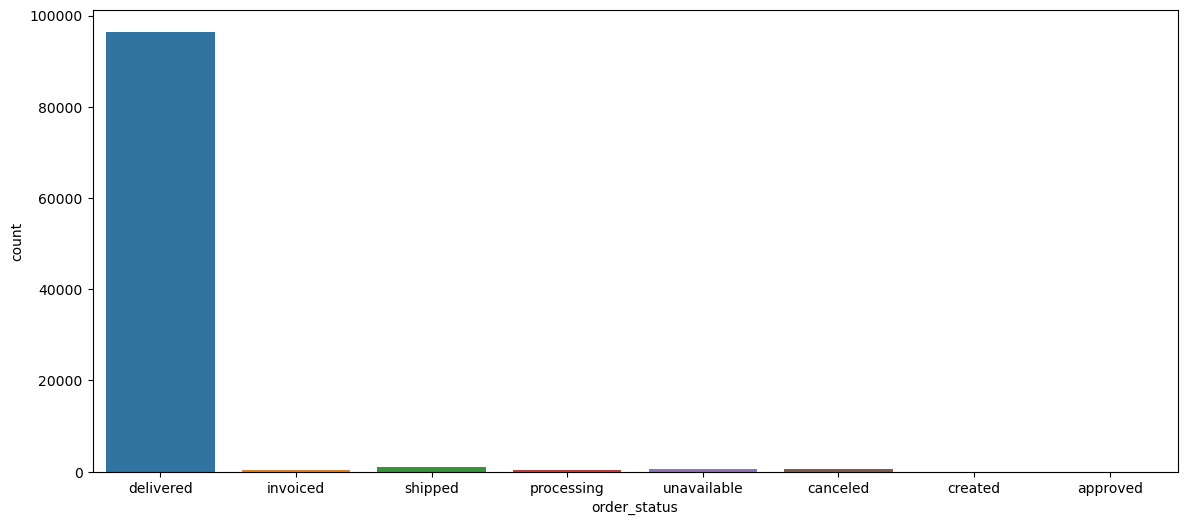

In [5]:
df_orders = olist_orders.merge(olist_customer, how= 'left', on ='customer_id')
fig, ax = plt.subplots(figsize = (14,6))
sns.countplot(df_orders, x='order_status', ax =ax)
plt.show()